In [50]:
# Import Library
#%reset
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import keras
from glob import glob
from keras.preprocessing.image import ImageDataGenerator #, img_to_array, 
from tensorflow.keras.utils import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet_v2 import MobileNetV2
import os
import pickle
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
import tensorflow as tf

#Usare scaler

# Prepare and Review Dataset

In [51]:
# Test and Train path
with open('newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('AllPixelBand3.pickle', 'rb') as handle:
    allPixel3 = pickle.load(handle)

# Identificare qualita' e suddivisione del dataset in maniera corretta tra train e test

 Resa bassa: 58 Resa media[4500,10000]: 1472 Resa alta(>10000): 31


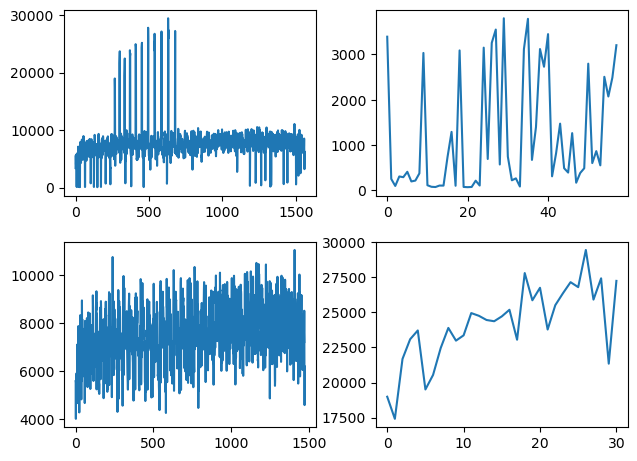

In [52]:
#taglio outliar
FilterResa3gtZero = newResa3!=0
newResa3 = newResa3[FilterResa3gtZero]
allPixel3 = allPixel3[FilterResa3gtZero,:,:]

LowValue = 1
Medium = 4000
HighValue = 12000
Resa3LowFilter = (newResa3<Medium) & (newResa3>LowValue)
Resa3MediumFilter = (newResa3>=Medium) & (newResa3<=HighValue)
Resa3HighFilter = (newResa3>HighValue)

Resa3Low = newResa3[Resa3LowFilter]
Resa3Medium = newResa3[Resa3MediumFilter]
Resa3High = newResa3[Resa3HighFilter]

Pixel3Low = allPixel3[Resa3LowFilter,:,:]
Pixel3Medium = allPixel3[Resa3MediumFilter,:,:]
Pixel3High = allPixel3[Resa3HighFilter,:,:]


print(" Resa bassa: "+str(len(Resa3Low))+ " Resa media[4500,10000]: "+ str(len(Resa3Medium))+ " Resa alta(>10000): "+ str(len(Resa3High)))

padding = 1.2
f, axarr = plt.subplots(2,2)
f.tight_layout(pad=padding)
axarr[0][0].plot(newResa3)
axarr[0][1].plot(Resa3Low)
axarr[1][0].plot(Resa3Medium)
axarr[1][1].plot(Resa3High)
plt.show()

In [53]:
def splitSet(X,Y):
    if X.shape[0] != Y.shape[0]:
        raise Exception("X and Y have different sizes")
    choice = np.random.choice(range(X.shape[0]), size=(int(X.shape[0]/2),), replace=False)
    ind = np.zeros(X.shape[0], dtype=bool)
    ind[choice] = True
    rest = ~ind
    return np.array(X[ind,:,:]),np.array(Y[ind]),np.array(X[rest,:,:]),np.array(Y[rest])

# Costruisco le immagini

[5503.7 7891.4 5227.  5149.8 4292.9 6056.8 7425.7 7580.2 6281.9 4838. ]


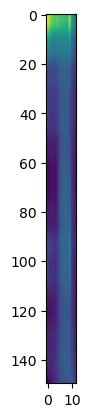

In [54]:
# Test and Train path
train_path = "dataset\\train\\"
test_path = "dataset\\test\\"
predict_path = "dataset\\predict\\Nuova cartella\\"

#training_setLowX, training_setLowY, test_setLowX, test_setLowY = splitSet(Pixel3Low,Resa3Low)
training_setMediumX,training_setMediumY, test_setMediumX, test_setMediumY = splitSet(Pixel3Medium,Resa3Medium)
#training_setHighX,training_setHighY, test_setHighX, test_setHighY = splitSet(Pixel3High,Resa3High)

#training_setX = np.concatenate([training_setLowX,training_setMediumX,training_setHighX],axis=0)
#training_setY = np.concatenate([training_setLowY,training_setMediumY,training_setHighY],axis=0)
training_setX = training_setMediumX
training_setY = training_setMediumY

#test_setX = np.concatenate([test_setLowX,test_setMediumX,test_setHighX],axis=0)
#test_setY = np.concatenate([test_setLowY,test_setMediumY,test_setHighY],axis=0)
test_setX = test_setMediumX
test_setY = test_setMediumY

print(training_setY[10:20])
plt.imshow(np.transpose(training_setX[0,:,:]))

#Train Set
for a in range(0,training_setX.shape[0]):
    img = Image.fromarray(training_setX[a,:,:])
    img.save(train_path+str(a)+'.tiff')

#Test Set
for a in range(0,test_setX.shape[0]):
    img = Image.fromarray(test_setX[a,:,:])
    img.save(test_path+str(a)+'.tiff')
    img.save(predict_path+str(a)+'.tiff')


In [55]:


# Costruiamo un dataframe Train
dFTrain = pd.DataFrame(columns=['id','target'])
dFTrain['id'] = [str(x)+".tiff" for x in list(range(0,training_setX.shape[0]))]
dFTrain['target'] = training_setY/Resa3Medium.max()
print(dFTrain.head())

# Costruiamo un dataframe Test
dFTest = pd.DataFrame(columns=['id','target'])
dFTest['id'] = [str(x)+".tiff" for x in list(range(0,test_setX.shape[0]))]
dFTest['target'] = test_setY/Resa3Medium.max()

# Prepare the dataset
#Train dataset
train_data = ImageDataGenerator().flow_from_dataframe(dataframe=dFTrain, target_size = (160,160),
                                                      directory=train_path,
                                                      x_col="id",
                                                      y_col="target",
                                                      class_mode="other")

#Test Dataset
test_data = ImageDataGenerator().flow_from_dataframe(dataframe=dFTest, target_size = (160,160),
                                                      directory=test_path,
                                                      x_col="id",
                                                      y_col="target",
                                                      class_mode="other")

       id    target
0  0.tiff  0.505640
1  1.tiff  0.498988
2  2.tiff  0.363910
3  3.tiff  0.497144
4  4.tiff  0.492787
Found 736 validated image filenames.
Found 736 validated image filenames.


In [56]:
print(dFTrain['target'].mean())
print(dFTrain['target'].median())

print(dFTest['target'].mean())
print(dFTest['target'].median())

0.6909326314926147
0.6979889869689941
0.6918872594833374
0.6948888301849365


# Creazione del modello di Vgg16

In [57]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')

In [58]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [59]:
base_model.trainable = False

In [60]:
model = Sequential()

In [61]:
model.add(base_model)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='linear'))


In [62]:
base_learning_rate = 0.01

model.compile(loss="mse", 
              optimizer=tf.keras.optimizers.Adam(base_learning_rate), 
              metrics=['mse', 'mae', 'mape'])

In [63]:
len(model.trainable_variables)

4

In [64]:
# After I added last layer in created model.
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_3 (Flatten)         (None, 32000)             0         
                                                                 
 dense_11 (Dense)            (None, 512)               16384512  
                                                                 
 dense_12 (Dense)            (None, 1)                 513       
                                                                 
Total params: 18,643,009
Trainable params: 16,385,025
Non-trainable params: 2,257,984
_________________________________________________________________


In [65]:
# I create compile part.
model.compile(loss = "mean_squared_error",
             optimizer = keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-03),
             metrics = ["mse","mae"])

# Training Model 

In [66]:
# Traning with model
batch_size = 32

hist_vgg16 = model.fit(train_data, 
                                epochs = 20,
                                validation_data=test_data
                                )

Epoch 1/20
23/23 [==============================] - 15s 557ms/step - loss: 7105.4512 - mse: 7105.4512 - mae: 19.7836 - val_loss: 0.0566 - val_mse: 0.0566 - val_mae: 0.1702
Epoch 2/20
23/23 [==============================] - 11s 466ms/step - loss: 2.6161 - mse: 2.6161 - mae: 1.3166 - val_loss: 9.5441 - val_mse: 9.5441 - val_mae: 3.0709
Epoch 3/20
23/23 [==============================] - 12s 527ms/step - loss: 5.2238 - mse: 5.2238 - mae: 2.1183 - val_loss: 5.0368 - val_mse: 5.0368 - val_mae: 2.2382
Epoch 4/20
23/23 [==============================] - 11s 478ms/step - loss: 2.7052 - mse: 2.7052 - mae: 1.2967 - val_loss: 0.1684 - val_mse: 0.1684 - val_mae: 0.3930
Epoch 5/20
23/23 [==============================] - 11s 473ms/step - loss: 0.6041 - mse: 0.6041 - mae: 0.5912 - val_loss: 0.0332 - val_mse: 0.0332 - val_mae: 0.1546
Epoch 6/20
23/23 [==============================] - 12s 512ms/step - loss: 0.6255 - mse: 0.6255 - mae: 0.6397 - val_loss: 1.4871 - val_mse: 1.4871 - val_mae: 1.2144
Epo

In [67]:
# Save the weights of model
#vgg16Model.save_weights("previsioneResa.h5")

# Andiamo a visualizzare i risultati della rete

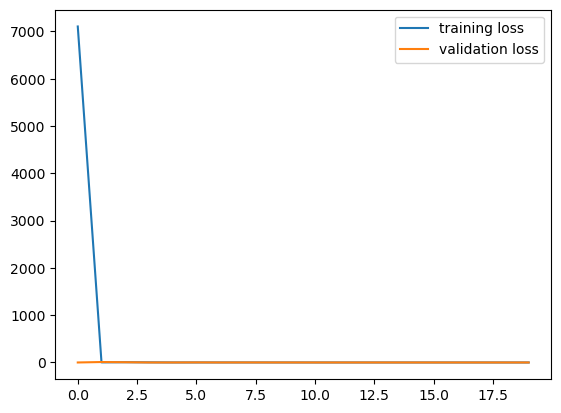

In [68]:

# Loss and Validation Loss

plt.plot(hist_vgg16.history["loss"], label = "training loss")
plt.plot(hist_vgg16.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

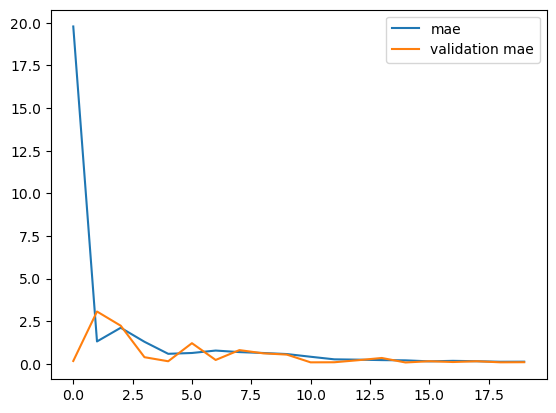

In [69]:
# Accuracy and Validation Accuracy
plt.plot(hist_vgg16.history["mae"], label = "mae")
plt.plot(hist_vgg16.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()

# Salviamo e carichiamo i risultati

In [70]:
'''import json, codecs
with open("previsioneResa.json","w") as f:
    json.dump(hist_vgg16.history, f)'''

'import json, codecs\nwith open("previsioneResa.json","w") as f:\n    json.dump(hist_vgg16.history, f)'

In [71]:
'''with codecs.open("./previsioneResa.json","r", encoding = "utf-8") as f:
    load_result = json.loads(f.read())'''

'with codecs.open("./previsioneResa.json","r", encoding = "utf-8") as f:\n    load_result = json.loads(f.read())'

# Vgg19

In [72]:
# Import VGG19 model
vgg19 = VGG19(input_shape=(32,32,3),include_top=False)

In [73]:
# Layers of vgg19
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [74]:
# add the layers of vgg16 in my created model.
vgg19Model = Sequential()
vgg19Model.add(vgg19)
vgg19Model.add(Flatten())

In [75]:
# Close the layers of vgg16
for layers in vgg19Model.layers:
    layers.trainable = False

In [76]:
# Last layer
vgg19Model.add(Dense(512,activation='relu'))
vgg19Model.add(Dense(1,activation='sigmoid'))

In [77]:
# the final version of the model
vgg19Model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dense_14 (Dense)            (None, 1)                 513       
                                                                 
Total params: 20,287,553
Trainable params: 263,169
Non-trainable params: 20,024,384
_________________________________________________________________


In [78]:
# I create compile part.
vgg19Model.compile(loss = "mean_squared_error",
             optimizer = "rmsprop",
             metrics = ["mse","mae"])

# Addestramento

In [79]:
# Traning with model
batch_size = 32

# Training with my created model
'''hisy_vgg19 = vgg19Model.fit_generator(train_data,
                               epochs = 20,
                               validation_data = test_data
                               )'''

'hisy_vgg19 = vgg19Model.fit_generator(train_data,\n                               epochs = 20,\n                               validation_data = test_data\n                               )'

# Visualizziamo i risultati ottenuti

In [80]:
# Loss And Validation Loss
'''plt.plot(hisy_vgg19.history["loss"], label = "training loss")
plt.plot(hisy_vgg19.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()'''

'plt.plot(hisy_vgg19.history["loss"], label = "training loss")\nplt.plot(hisy_vgg19.history["val_loss"], label = "validation loss")\nplt.legend()\nplt.show()'

In [81]:
# Accuracy And Validation Accuracy
'''plt.plot(hisy_vgg19.history["mae"], label = "mae")
plt.plot(hisy_vgg19.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()'''

'plt.plot(hisy_vgg19.history["mae"], label = "mae")\nplt.plot(hisy_vgg19.history["val_mae"], label = "validation mae")\nplt.legend()\nplt.show()'

In [82]:
val = dFTest['target'].values
print(len(val))
print(np.where(val == 1.0))

736
(array([], dtype=int64),)


In [85]:
predict_path = "dataset\\predict\\"
real = [0.7098427508416938,0.7070679681851049,0.560891196250226,0.756299728426654,0.6950921908893709]
predict_data = ImageDataGenerator().flow_from_directory(directory=predict_path,target_size=(160,160))

val = dFTest['target'].values
#print(len(val))
#print(np.where(val == 1.0))
#print(dFTest['target'].where(1.0))
print(dFTest['target'][711:714])
print(dFTest['target'].mean())                                                    
prediction = model.predict(predict_data)
print(prediction)                                         

Found 736 images belonging to 1 classes.
711    0.684490
712    0.836885
713    0.496737
Name: target, dtype: float32
0.6918872594833374
23/23 [==============================] - 5s 191ms/step
[[0.74484265]
 [0.729233  ]
 [0.80082697]
 [0.76422524]
 [0.76422524]
 [0.75377536]
 [0.7768774 ]
 [0.76790583]
 [0.7641871 ]
 [0.77949077]
 [0.755401  ]
 [0.74908876]
 [0.7637865 ]
 [0.7813547 ]
 [0.7591142 ]
 [0.73881304]
 [0.7734996 ]
 [0.73374796]
 [0.77949077]
 [0.788865  ]
 [0.755401  ]
 [0.7329864 ]
 [0.75205374]
 [0.77039415]
 [0.7643129 ]
 [0.7727712 ]
 [0.76790583]
 [0.74484265]
 [0.7965219 ]
 [0.7499074 ]
 [0.78211987]
 [0.7473288 ]
 [0.7363662 ]
 [0.729233  ]
 [0.7858438 ]
 [0.76422524]
 [0.76302755]
 [0.7701602 ]
 [0.755401  ]
 [0.77560693]
 [0.7525336 ]
 [0.7315088 ]
 [0.8069184 ]
 [0.729233  ]
 [0.79036236]
 [0.8013243 ]
 [0.7734996 ]
 [0.752818  ]
 [0.76757133]
 [0.7482028 ]
 [0.7698562 ]
 [0.7667401 ]
 [0.76986927]
 [0.729233  ]
 [0.7741977 ]
 [0.7591142 ]
 [0.7810625 ]
 [0.775606

(736, 1)
(736,)


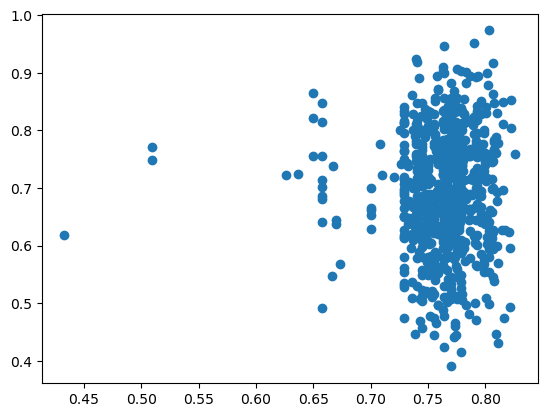

In [86]:
print(prediction.shape)
print(training_setY.shape)
plt.scatter(prediction[:,0],test_setY/Resa3Medium.max())